# Quick start guide


## Installation
### Stable
Fri can be installed via the Python Package Index (PyPI).

If you have `pip` installed just execute the command

    pip install fri
   
to get the newest stable version.

The dependencies should be installed and checked automatically.
If you have problems installing please open issue at our [tracker](https://github.com/lpfann/fri/issues/new).

### Development
To install a bleeding edge dev version of `FRI` you can clone the GitHub repository using

    git clone git@github.com:lpfann/fri.git

and then check out the `dev` branch: `git checkout dev`.

We use [poetry](https://poetry.eustace.io/) for dependency management.

Run

    poetry install

in the cloned repository to install `fri` in a virtualenv.



To check if everything works as intented you can use `pytest` to run the unit tests.
Just run the command

    poetry run pytest

in the main project folder

## Using FRI
Now we showcase the workflow of using FRI on a simple classification problem.

### Data
To have something to work with, we need some data first.
`fri` includes a generation method for binary classification and regression data.

In our case we need some classification data.

In [1]:
import numpy as np
# fixed Seed for demonstration
STATE = np.random.RandomState(123)

from fri import genClassificationData

We want to create a small set with a few features.

Because we want to showcase the all-relevant feature selection, we generate multiple strongly and weakly relevant features.

In [2]:
n = 300
features = 6
strongly_relevant = 2
weakly_relevant = 2

In [3]:
X,y = genClassificationData(n_samples=n,
                            n_features=features,
                            n_strel=strongly_relevant,
                            n_redundant=weakly_relevant,
                            random_state=STATE)

The method also prints out the parameters again.

In [4]:
X.shape

(300, 6)

We created a binary classification set with 6 features of which 2 are strongly relevant and 2 weakly relevant.

#### Preprocess
Because our method expects mean centered data we need to standardize it first.
This centers the values around 0 and deviation to the standard deviation

In [5]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

### Model
Now we need to creata a Model. 

We use the `FRI` module.


In [6]:
import fri

`fri` provides a convenience class `fri.FRI` to create a model.

`fri.FRI` needs the type of problem as a first argument of type `ProblemName`.

Depending on the Problem you want to analyze pick from one of the available models in `ProblemName`.

In [7]:
list(fri.ProblemName)

[<ProblemName.CLASSIFICATION: [<class 'fri.model.classification.Classification'>, <ProblemName.CLASSIFICATION: 1>]>,
 <ProblemName.REGRESSION: [<class 'fri.model.regression.Regression'>, <ProblemName.REGRESSION: 2>]>,
 <ProblemName.ORDINALREGRESSION: [<class 'fri.model.ordinal_regression.OrdinalRegression'>, <ProblemName.ORDINALREGRESSION: 3>]>,
 <ProblemName.LUPI_CLASSIFICATION: [<class 'fri.model.lupi_classification.LUPI_Classification'>, <ProblemName.LUPI_CLASSIFICATION: 4>]>,
 <ProblemName.LUPI_REGRESSION: [<class 'fri.model.lupi_regression.LUPI_Regression'>, <ProblemName.LUPI_REGRESSION: 5>]>,
 <ProblemName.LUPI_ORDREGRESSION: [<class 'fri.model.lupi_ordinal_regression.LUPI_OrdinalRegression'>, <ProblemName.LUPI_ORDREGRESSION: 6>]>]

Because we have Classification data we use the `ProblemName.CLASSIFICATION` to instantiate our model.

In [10]:
fri_model = fri.FRI(fri.ProblemName.CLASSIFICATION,
                    loss_slack=0.2,
                    w_l1_slack=0.2,
                    random_state=STATE)

In [11]:
fri_model

FRI(loss_slack=0.2, n_jobs=1, n_param_search=10, n_probe_features=20,
    normalize=True,
    problemName=<ProblemName.CLASSIFICATION: [<class 'fri.model.classification.Classification'>, <ProblemName.CLASSIFICATION: 1>]>,
    random_state=RandomState(MT19937) at 0x25AFE7F5E18, verbose=0,
    w_l1_slack=0.2)

We used no parameters for creation so the defaults are active.

#### Fitting to data
Now we can just fit the model to the data using `scikit-learn` like commands.

In [12]:
fri_model.fit(X_scaled,y)

FRI(loss_slack=0.2, n_jobs=1, n_param_search=10, n_probe_features=20,
    normalize=True,
    problemName=<ProblemName.CLASSIFICATION: [<class 'fri.model.classification.Classification'>, <ProblemName.CLASSIFICATION: 1>]>,
    random_state=RandomState(MT19937) at 0x25AFE7F5E18, verbose=0,
    w_l1_slack=0.2)

The resulting feature relevance bounds are saved in the `interval_` variable.

In [13]:
fri_model.interval_

array([[1.99563942e-01, 3.79968717e-01],
       [2.12189365e-01, 4.19893133e-01],
       [0.00000000e+00, 4.62347531e-01],
       [0.00000000e+00, 4.58075157e-01],
       [0.00000000e+00, 4.08336422e-02],
       [1.59611431e-10, 3.54807291e-02]])

If you want to print out the relevance class use the `print_interval_with_class()` function.

In [14]:
print(fri_model.print_interval_with_class())

############## Relevance bounds ##############
feature: [LB -- UB], relevance class
      0: [0.2 -- 0.4], Strong relevant
      1: [0.2 -- 0.4], Strong relevant
      2: [0.0 -- 0.5], Weak relevant
      3: [0.0 -- 0.5], Weak relevant
      4: [0.0 -- 0.0], Irrelevant
      5: [0.0 -- 0.0], Irrelevant



The bounds are grouped in 2d sublists for each feature.


To acess the relevance bounds for feature 2 we would use

In [15]:
fri_model.interval_[2]

array([0.        , 0.46234753])

The relevance classes are saved in the corresponding variable `relevance_classes_`:

In [16]:
fri_model.relevance_classes_

array([2, 2, 1, 1, 0, 0])

`2` denotes strongly relevant features, `1` weakly relevant and `0` irrelevant.

#### Plot results

The bounds in numerical form are useful for postprocesing.
If we want a human to look at it, we recommend the plot function `plot_relevance_bars`.

We can also color the bars according to `relevance_classes_`

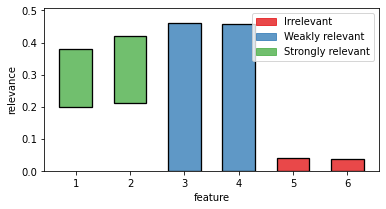

In [17]:
# Import plot function
from fri.plot import plot_relevance_bars
import matplotlib.pyplot as plt
%matplotlib inline

# Create new figure, where we can put an axis on
fig, ax = plt.subplots(1, 1,figsize=(6,3))

# plot the bars on the axis, colored according to fri
out = plot_relevance_bars(ax,fri_model.interval_,classes=fri_model.relevance_classes_)

### Setting constraints manually
Our model also allows to compute relevance bounds when the user sets a given range for the features.

We use a dictionary to encode our constraints.


In [18]:
preset = {}

#### Example
As an example, let us constrain the third from our example to the minimum relevance bound.



In [19]:
preset[2] = fri_model.interval_[2, 0]

We use the function `constrained_intervals`.

Note: we need to fit the model before we can use this function.
We already did that, so we are fine.

In [20]:
const_ints = fri_model.constrained_intervals(preset=preset)

In [21]:
const_ints

array([[2.15480177e-01, 3.79968718e-01],
       [2.35275798e-01, 4.19820750e-01],
       [0.00000000e+00, 0.00000000e+00],
       [2.55994922e-01, 4.40560181e-01],
       [0.00000000e+00, 3.24886271e-02],
       [2.49563132e-11, 3.32969678e-02]])

Feature 3 is set to its minimum (at 0).

How does it look visually?

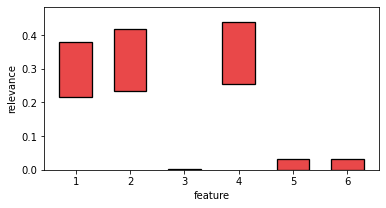

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(6,3))
out = plot_relevance_bars(ax, const_ints)

Feature 3 is reduced to its minimum (no contribution).

In turn, its correlated partner feature 4 had to take its maximum contribution.

### Print internal Parameters

If we want to take at internal parameters, we can use the `verbose` flag in the model creation.

In [23]:
fri_model = fri.FRI(fri.ProblemName.CLASSIFICATION, verbose=True, random_state=STATE)

In [24]:
fri_model.fit(X_scaled,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


******************** Best found baseline model ********************
Classification_SVM(C=0.053126576297160326)
score:  0.9766669259288066
'loss: 59.43457025190969'
'w_l1: 3.186624268460236'
'w: shape (6,)'
'b: shape ()'
'slack: shape (300,)'
******************************


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
INFO:root:**** Feature Selection ****
INFO:root:Lower Probe Statistic
INFO:root:ProbeStatistic(lower_threshold=0.0, upper_threshold=0.0, n_probes=11)
INFO:root:Upper Probe Statistic
INFO:root:ProbeStatistic(lower_threshold=-0.08953248574047366, upper_threshold=0.11254187120595376, n_probes=10)


FRI(loss_slack=0.001, n_jobs=1, n_param_search=10, n_probe_features=20,
    normalize=True,
    problemName=<ProblemName.CLASSIFICATION: [<class 'fri.model.classification.Classification'>, <ProblemName.CLASSIFICATION: 1>]>,
    random_state=RandomState(MT19937) at 0x25AFE7F5E18, verbose=True,
    w_l1_slack=0.001)

This prints out the parameters of the baseline model

One can also see the best selected hyperparameter according to gridsearch and the training score of the model in `score`.


### Multiprocessing
To enable multiprocessing simply use the `n_jobs` parameter when init. the model.

It expects an integer parameter which defines the amount of processes used.
`n_jobs=-1` uses all available on the CPU.

In [25]:
fri_model = fri.FRI(fri.ProblemName.CLASSIFICATION,
                    n_jobs=-1,
                    verbose=1,
                    random_state=STATE)

In [26]:
fri_model.fit(X_scaled,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  18 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


******************** Best found baseline model ********************
Classification_SVM(C=31.987051186027454)
score:  0.9900001111123456
'loss: 8.419355087574399'
'w_l1: 47.66916725351819'
'w: shape (6,)'
'b: shape ()'
'slack: shape (300,)'
******************************


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
INFO:root:**** Feature Selection ****
INFO:root:Lower Probe Statistic
INFO:root:ProbeStatistic(lower_threshold=-0.039150504419478684, upper_threshold=0.046026976488379744, n_probes=3)
INFO:root:Upper Probe Statistic
INFO:root:ProbeStatistic(lower_threshold=-0.08997621770611755, upper_threshold=0.16031569991384712, n_probes=6)


FRI(loss_slack=0.001, n_jobs=-1, n_param_search=10, n_probe_features=20,
    normalize=True,
    problemName=<ProblemName.CLASSIFICATION: [<class 'fri.model.classification.Classification'>, <ProblemName.CLASSIFICATION: 1>]>,
    random_state=RandomState(MT19937) at 0x25AFE7F5E18, verbose=1,
    w_l1_slack=0.001)